# Finding Best Quartic Fit - 2 dot system

The Goal of this tutorial is to demonstrate the `fit()` function as it creates a quartic potential well of best fit.

**Section 0.0 `fit()` Function**
> Details about the fit function to note before the tutorial

**Section 1.0 Basic Fit Example**
> Creating a basic quartic potential well with the same parameters as the fitted well to check for validity. 
We will compare parameter values and plot the potentials.

**Section 2.0 Adding Complexity**
> Creating a slightly more complex well and adding noise to demonstrate the functions ability to smooth the data and create the potential of best fit

# Section 0.0 - `fit()` Function

First, Import all of the needed modules

In [1]:
# Import Modules
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
from qudipy.utils.constants import Constants
from qudipy.exchange import fitting as ft
from qudipy.potential import GridParameters

### 0.1 What is the data being fit to?

The data is being fit to the following quartic function:<br>

$$ U_{fit}(x,y) = \frac{m \omega_0^2}{2}\left(\frac{[(x-x_0)^2-d^2]^2}{4d^2} + y^2\right) + e \mathscr{E} x + U_0$$

where:
- $x_0$ is the position of the middle of the well<br>
- $\omega_0$ is the potential at $x_0$<br>
- $d$ is the dot seperation<br>
- $\mathscr{E}$ is the electric field<br>
- $U_0$ is the average lowest energy of the two valleys<br>
- $m$ is the mass of a free electron<br>
- $e$ is the charge of an electron<br>


### 0.2 What is the `fit()` Function
To find the potential of best fit we must call the **'fit'** function from the **qudipy.exchange.fitting.py** module. The function has the following parameters and keyword arguments:

`fit(U_data, gparams, y_slice=0, material='vacuum', return_params=False)`

 **Parameters** <br>
> - `U_data` = 2D array of potential data to be fit <br>
> - `gparams` = GridParameters object (follow path qudipy.potential.grid_params.py for more)<br>

**Keyword Arguments** <br>
> - `y_slice=0` = The y value that the well is centered on, default is at 0 <br>
> - `material='vacuum'` = The material used. Default is vacuum <br>
> - `return_params=False` = The predicate to determine if the user wishes to return a dictionary of parameter values. Default is False, and the function will return the 2D array of best fitting potential values. <br>


***
**keys for return_params=True**
> *When return_params=True the function will return a dictionary with parameter values inside. The following are the keys used to call out these parameters. If return_params=False, the function will return the 2D Array of fit values.*
> - <font color=green>'U_fit'</font> : 2D Array of fitted potential values <br>
> - <font color=green>'xrange'</font> : 1D Array of x-values interpolated over <br>
> - <font color=green>'yrange'</font> : 1D Array of y-values interpolated over <br>
> - <font color=green>'error'</font> : Int representing the relative error of the fit <br>
>
> <ins>**Best Fit Parameters**</ins>
> - <font color=green>'dot_sep'</font> : The dot_seperation found via optimization<br>
> - <font color=green>'e_field'</font> : The electric field found via optimization<br>
> - <font color=green>'omega0'</font> : The potential at $x_0$ found via optimization<br>
> - <font color=green>'x_centre'</font> : The centre of the well, $x_0$ found via optimization<br>
> - <font color=green>'U0'</font> : The average lowest energy found via optimization<br>

# Section 1.0 Basic Fit Example

### 1.1 Create Potential Data

First, let's create a 2D Array of potential values that we will pass to the fitting function. Let us create a potential idential to the fitting function so that we may verify our values.

Let's create a well of the shape specified in *0.1* so that we can test that the fitted well gives us back the same potentails.

In [2]:
# Create Parameters for Data Potential
d = 150e-12 # half dot seperation (initial guess)
E1 = 2 # min Energy of first well
E2 = 2 # min Energy of second well
Emax = 4 # Energy at local max
U0 = (E2+E1)/2 # average lowest energy
e = Constants('Si/SiO2').e # electron charge
m = Constants('Si/SiO2').m0 # mass of free electron
epsilon = (E2-E1)/(e*2*d) # electric field
omega0 = 2/d * np.sqrt((1/m)*(2*Emax - E2 - E1)) # potential at x0
x0 = 0

# x and y values
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, sparse=False, indexing='xy')


U_data = (m * omega0**2)/2 *\
            (np.square(np.square(x_vals - x0) - d**2) / (4*d**2) + np.square(y_vals)) +\
            epsilon * e * x_vals + U0

### 1.2 Graph the data plots

Next, graph U_data, the potential that we wish to have fitted. 

Below we have plotted x vs. U, y vs. U, xy vs. U and a 3D plot of the potential to provide an in depth view of the potential that we will pass to the fitting function.

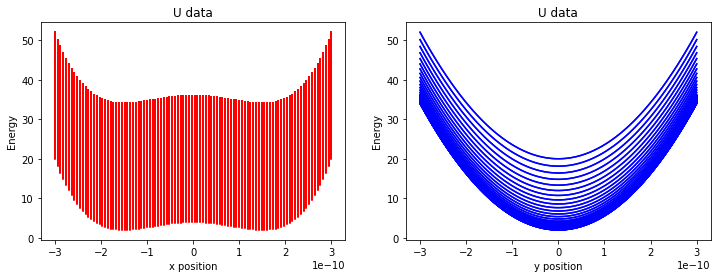

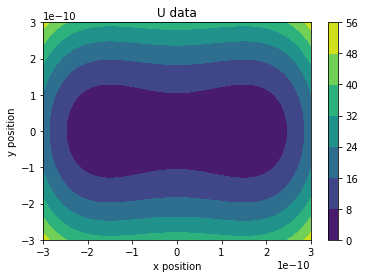

Text(0.5, 0.92, 'Quartic Potential')

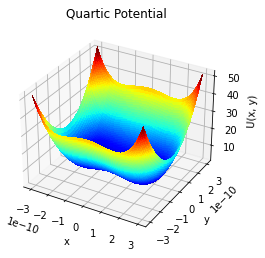

In [3]:
# Graph the data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_data, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U data')

# Potential - y vs. U
ax2.plot(y_vals, U_data, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_data)
plt.colorbar()
plt.title('U data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_data, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential')

### 1.3 Find quartic well of best fit

We will now use the `fit()` function to find the potential of best fit. We will compare the optimized parameters next to the parameters that we created the data from to verify that our function has suceeded in finding the appropriate parameters of best fit.

In [4]:
# x and y coordinates same as the coords from our data
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, sparse=False, indexing='xy')
gparams = GridParameters(x, y)

# Pass all information to fitting function
U_fit_dict = ft.fit(U_data, gparams, y_slice=0, material='Si/SiO2', return_params=True)

# Retrieve parameters
U_fit = U_fit_dict['U_fit']
d_fit = U_fit_dict['dot_sep']
epsilon_fit = U_fit_dict['e_field']
omega0_fit = U_fit_dict['omega0']
x0_fit = U_fit_dict['x_centre']
U0_fit = U_fit_dict['U0']
err = U_fit_dict['error']

# Print off parameter values and compare with created potential parameter values
info_dict = {'dot_sep': [d_fit, d], 'e_field': [epsilon_fit, epsilon], \
             'omega0':[omega0_fit, omega0], 'x_centre': [x0_fit, x0], 'U0': [U0_fit, U0]}
df = pd.DataFrame(data=info_dict, index=['fit', 'data'])
display(df)
print('relative error:', err,'%')

,dot_sep,e_field,omega0,x_centre,U0
fit,1.484848e-10,-0.0,2.820774e+25,-0.0,2.004073
data,1.500000e-10,0.0,2.793986e+25,0.0,2.000000


relative error: 0.025102097323866458 %


### 1.4 Graph The Quartic Potential of Best Fit

We will now graph `U_fit`

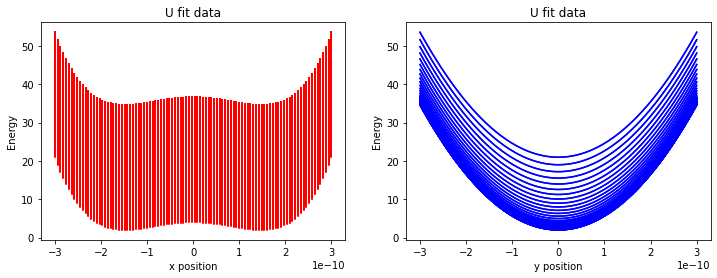

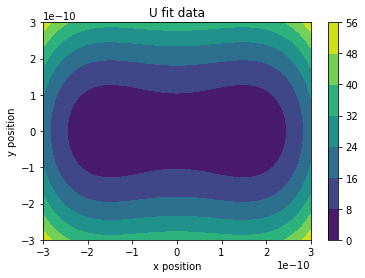

Text(0.5, 0.92, 'Quartic Potential of best Fit')

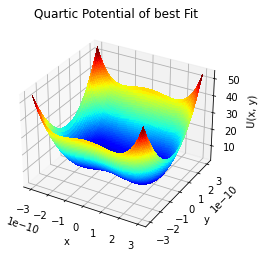

In [5]:
# Graph the fitted potential

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_fit, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U fit data')

# Potential - y vs. U
ax2.plot(y_vals, U_fit, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U fit data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_fit)
plt.colorbar()
plt.title('U fit data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

# Plot 3D Figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_fit, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential of best Fit')

# Section 2.0 Adding Complexity 

Since we have verified the simplest case, let us add complexity to our data by changing the position of the energies of the wells and adding some noise. We will follow the same procedure as in Section 1.0.

### 2.1 Define Parameters

We will create another quartic well, but this time we will add random noise to simulate a more realistic situation.

In [6]:
# Create Parameters for Data Potential
d = 150e-12 # half dot seperation (initial guess)
E1 = 4 # min Energy of first well
E2 = 0 # min Energy of second well
Emax = 6 # Energy at local max
U0 = (E2+E1)/2 # average lowest energy
e = Constants('Si/SiO2').e # electron charge
m = Constants('Si/SiO2').m0 # mass of free electron
epsilon = (E2-E1)/(e*2*d) # electric field
omega0 = 2/d * np.sqrt((1/m)*(2*Emax - E2 - E1)) # potential at x0
x0 = 0

# x and y values
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, sparse=False, indexing='xy')


U_data = (m * omega0**2)/2 *\
            (np.square(np.square(x_vals - x0) - d**2) / (4*d**2) + np.square(y_vals)) +\
            epsilon * e * x_vals + U0


# Adding artificial noise (will not be needed in practice)
np.random.seed(469230) # fix seed for reproducibility

noise = np.random.rand(*U_data.shape)
error = 0.05 # error rate of 5%

for index, value in np.ndenumerate(noise):
    noise[index] = 1 if value < error else 0

U_data = U_data + noise

### 2.2 Graph Data

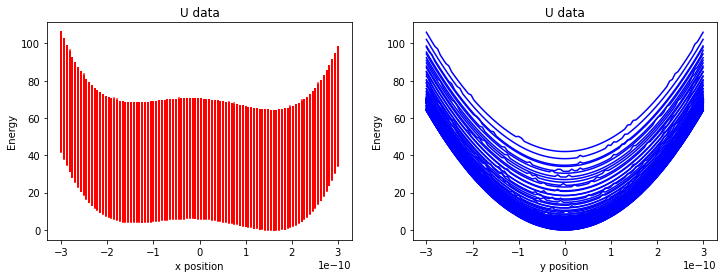

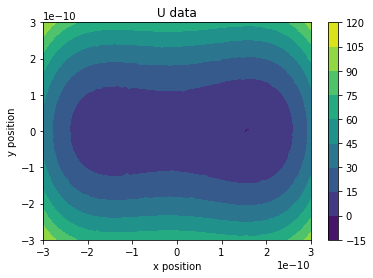

Text(0.5, 0.92, 'Quartic Potential')

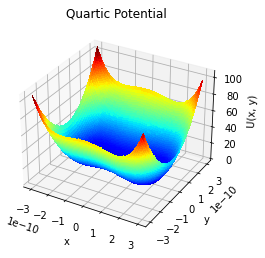

In [7]:
# Graph the data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_data, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U data')

# Potential - y vs. U
ax2.plot(y_vals, U_data, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_data)
plt.colorbar()
plt.title('U data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_data, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential')

### 2.2 Retrieve Fit Parameters and Compare

In [8]:
# x and y coordinates same as the coords from our data
x = np.linspace(-2*d, 2*d, 100, endpoint=True)
y = np.linspace(-2*d, 2*d, 100, endpoint=True)
x_vals, y_vals = np.meshgrid(x,y, sparse=False, indexing='xy')
gparams = GridParameters(x, y)

# Pass all information to fitting function
U_fit_dict = ft.fit(U_data, gparams, y_slice=0, material='Si/SiO2', return_params=True)

# Retrieve parameters
U_fit = U_fit_dict['U_fit']
d_fit = U_fit_dict['dot_sep']
epsilon_fit = U_fit_dict['e_field']
omega0_fit = U_fit_dict['omega0']
x0_fit = U_fit_dict['x_centre']
U0_fit = U_fit_dict['U0']
error = U_fit_dict['error']

# Print off parameter values and compare with created potential parameter values
info_dict = {'dot_sep': [d_fit, d], 'e_field': [epsilon_fit, epsilon], \
             'omega0':[omega0_fit, omega0], 'x_centre': [x0_fit, x0], 'U0': [U0_fit, U0]}
df = pd.DataFrame(data=info_dict, index=['fit', 'data'])
display(df)
print('relative error:',error,'%')

,dot_sep,e_field,omega0,x_centre,U0
fit,1.666667e-10,-5.516246e+28,3.401623e+25,-0.0,2.471076
data,1.500000e-10,-8.322012e+28,3.951293e+25,0.0,2.000000


relative error: 0.3967249408140252 %


### 2.3 Plot Fitted Potential

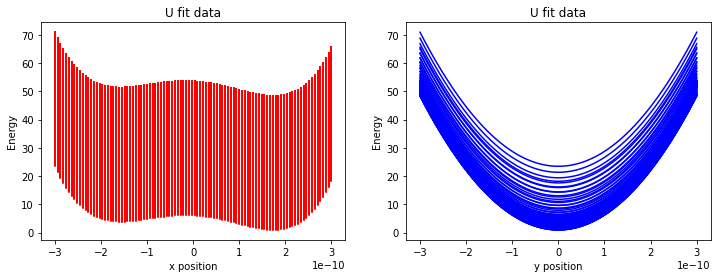

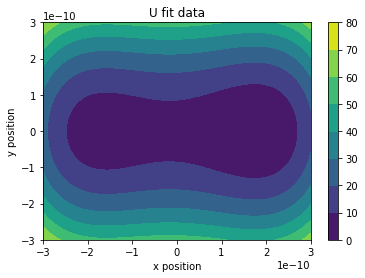

Text(0.5, 0.92, 'Quartic Potential of best Fit')

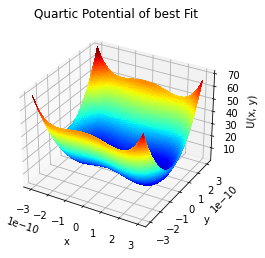

In [9]:
# Graph the fitted potential

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

# Potential - x vs. U
ax1.plot(x_vals, U_fit, 'r')
ax1.set_xlabel('x position')
ax1.set_ylabel('Energy')
ax1.set_title('U fit data')

# Potential - y vs. U
ax2.plot(y_vals, U_fit, 'b')
ax2.set_xlabel('y position')
ax2.set_ylabel('Energy')
ax2.set_title('U fit data')

plt.show()

# Potential - xy vs. U
plt.contourf(x,y, U_fit)
plt.colorbar()
plt.title('U fit data')
plt.xlabel('x position')
plt.ylabel('y position')
plt.show()

# Plot 3D Figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x_vals, y_vals, U_fit, rstride=1, cstride=1,
                       cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('U(x, y)')
ax.set_title('Quartic Potential of best Fit')